In [1]:
import csv
import pdb
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV
from sklearn.model_selection import train_test_split
import numpy as np

from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score

dataset_dictionary = {}
header_index = {}

#seed_val = 126
seed_val = 1991

#datatype = ["int", "int", "str", "str", "str", "int", "int", "str", "str", "str", "int", "int", "bool", "bool", "str", "str", "bool", "int", "str", "str"]
catch_outlier=True

#with open('data/train.csv') as csv_file:
with open('data/cleaned_data_ENG.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',' )
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            print(f'Column names are {", ".join(row)}')

            for header in range(0, len(row)):
                dataset_dictionary[row[header]] = []
                header_index[header] = row[header]
            line_count += 1
        else:
            ##lets skip points with salary range at 0
            if row[0] == "0" or row[1] == "0" or row[0] == "" or row[1] == "":
                continue
            
            if catch_outlier:
                if row[0] == "49000000":
                  print("Saw crazy it outlier")
                  row[0] = "49000"
                  row[1] = "49000"

                  
            for i in range(0, len(row)):
                dataset_dictionary[ header_index[i] ].append(row[i])
            
            line_count += 1


##now lets concatenate all the words we care about for a particular job posting
#job title, seniority, address, skills, roles, industries, stage
## then I'll make words for "is_public, is_acquired, and remote_ok" based on T/F values
for i in range(len(dataset_dictionary["address"])):
    dataset_dictionary["address"][i] = dataset_dictionary["address"][i].replace(" ", "_")


dataset_dictionary["avg_salary"] = []
for i in range(len(dataset_dictionary["min_salary"])):
    avg = ( float(dataset_dictionary["min_salary"][i]) + float(dataset_dictionary["max_salary"][i] ) ) / 2
    dataset_dictionary["avg_salary"].append(avg)

dataset_processed = zip( dataset_dictionary["job_title"], dataset_dictionary["seniority"], dataset_dictionary["address"], dataset_dictionary["skills"], dataset_dictionary["roles"], dataset_dictionary["industries"], dataset_dictionary["stage"] )

# ('Linux C Developer', 'regular', 'Salt Lake City_UT_USA', 'artificial_intelligence,deep_learning,machine_learning,linux,c,embedded', 'developer', 'consumer_electronics,aerospace,software,drones', '')


dataset_merged = []

for record in dataset_processed:
    ##got a tuple, now iterate through all its values
    new_list  = []
    for t in record:
        tlist = t.split(",")
        tlist = [val for val in tlist if val != '']
        
        new_list.extend(tlist)
    dataset_merged.append(new_list)

for i in range(len(dataset_merged)):
    job_desc = dataset_merged[i][0]
    job_desc = job_desc.replace("/", " ")
    job_desc = job_desc.replace("(", " ")
    job_desc = job_desc.replace(")", " ")
    job_desc = job_desc.lower()
    
    job_desc = re.sub(r'back[\s-]end', "backend", job_desc)    
    job_desc = re.sub(r'front[\s-]end', "frontend", job_desc)    
    ##fix front end and backend
    cleaned_desc = job_desc.split(" ")
    del dataset_merged[i][0]
    new_list = cleaned_desc + dataset_merged[i]
    dataset_merged[i] = new_list

for i in range(len(dataset_merged)):
    pub = dataset_dictionary["is_public"][i] 
    acq = dataset_dictionary["is_acquired"][i]
    remote = dataset_dictionary["remote_ok"][i]

    if pub == "True":
        dataset_merged[i].append("is_pub")
    elif pub == "False":
        dataset_merged[i].append("isnt_pub")

    if acq == "True":
        dataset_merged[i].append("is_acq")
    elif acq == "False":
        dataset_merged[i].append("isnt_acq")

    if remote == "True":
        dataset_merged[i].append("is_remote")
    elif remote == "False":
        dataset_merged[i].append("isnt_remote")

dataset_strings = []
for i in range(len(dataset_merged)):
    dataset_strings.append( " ".join(dataset_merged[i]) )

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(dataset_strings)

#print(vectorizer.get_feature_names() )
print(X.shape)
print("Num features: ")
print(len(vectorizer.get_feature_names()))

##train test split 
salary_options = ["avg_salary", "min_salary", "max_salary"]
salary_model_data = {}

##convert min and max salaries to floats
for sal_in in range(len(dataset_dictionary["min_salary"])):
    dataset_dictionary["min_salary"][sal_in] = float( dataset_dictionary["min_salary"][sal_in] )
    dataset_dictionary["max_salary"][sal_in] = float( dataset_dictionary["max_salary"][sal_in] )


for el in salary_options:
    X_train, X_test, y_train, y_test = train_test_split( X, dataset_dictionary[el] , random_state=seed_val, test_size=500)
    salary_model_data[el] = {}
    salary_model_data[el]["X_train"] = X_train
    salary_model_data[el]["X_test"] = X_test
    salary_model_data[el]["y_train"] = y_train
    salary_model_data[el]["y_test"] = y_test

    #salary_model_data[el]["regressor"] = LinearRegression(fit_intercept=True)
    salary_model_data[el]["regressor"] = Ridge(fit_intercept=True)
    #salary_model_data[el]["regressor"] = Lasso(max_iter=5000, alpha=1.0, fit_intercept=True)
    #salary_model_data[el]["regressor"] = LassoCV(cv=20, max_iter=5000, fit_intercept=True)

for el in salary_options:
    salary_model_data[el]["regressor"].fit(  X=salary_model_data[el]["X_train"], \
            y=salary_model_data[el]["y_train"] )

##Calculate how good the model is
for el in salary_options:
    #mean_absolute_error, mean_squared_error, median_absolute_error, r2_score
    y_pred = salary_model_data[el]["regressor"].predict( salary_model_data[el]["X_test"] )
    y_true = salary_model_data[el]["y_test"]

    y_pred_train = salary_model_data[el]["regressor"].predict( salary_model_data[el]["X_train"] )
    y_true_train = salary_model_data[el]["y_train"]

    salary_model_data[el]["y_pred"] = y_pred
    salary_model_data[el]["y_pred_train"] = y_pred_train
                  
    datasets = [ ("test", y_pred, y_true), ("train", y_pred_train, y_true_train) ]

    for d in datasets:
        salary_model_data[el]["MSE_"+d[0]] = mean_squared_error(d[2], d[1])
        salary_model_data[el]["MAE_"+d[0]] = mean_absolute_error(d[2], d[1])
        salary_model_data[el]["MEDAE_"+d[0]] = median_absolute_error(d[2], d[1])
        salary_model_data[el]["r2_"+d[0]] = r2_score(d[2], d[1])

metric_names = ["MSE", "MAE", "MEDAE", "r2"]
dataset_names = ["_test", "_train"]
for el in salary_options:
    print("Summary data for " + str(el) + " model ")
    for m in metric_names:
        print(m + ":")
        for d in dataset_names:
            print(d + ": " + str(salary_model_data[el][m+d]))


print("Done reading in.")

Column names are , max_salary, min_salary, job_title, seniority, address, min_size, max_size, skills, roles, industries, total_investments, founded_on, is_acquired, is_public, company_description, job_description, remote_ok, coolness_score, coolness_reasons, stage, NYC, LA, SF, SEA, senior, seniority_regular, seniority_senior, seniority_junior, seniority_manager, seniority_staff, seniority_cxo, seniority_vp, seniority_director, seniority_intern, skills_javascript, skills_python, skills_html, skills_css, skills_aws, skills_java, skills_node, skills_ruby, skills_angular, skills_ios, skills_react, skills_linux, skills_android, skills_rails, skills_c, back_end, full_stack, front_end, avg_size
(10929, 3007)
Num features: 
3007
Summary data for avg_salary model 
MSE:
_test: 579004080.2398479
_train: 465151158.12034255
MAE:
_test: 17772.41161202595
_train: 14880.890779134983
MEDAE:
_test: 13793.275084359047
_train: 11356.84916953821
r2:
_test: 0.4301887058813745
_train: 0.5562460079479625
Sum

In [2]:
import matplotlib.pyplot as plt


i=1
fig=plt.figure(figsize=(18, 16))

for el in salary_options:

    y_train_predictions = salary_model_data[el]["y_pred_train"]
    y_train_true = salary_model_data[el]["y_train"]
    
    #true_v_pred = list(zip(y_train_true, y_train_predictions))
    #true_v_pred.sort()
    
    #true_sorted = [x[0] for x in true_v_pred]
    #pred_sorted = [x[1] for x in true_v_pred]
    
    true_sorted_indices = np.argsort(y_train_true)
    true_sorted = [y_train_true[true_sorted_indices[i]] for i in range(len(true_sorted_indices))]
    pred_sorted = [y_train_predictions[true_sorted_indices[i]] for i in range(len(true_sorted_indices))]
    
    
    xvals = range(len(true_sorted))
    plt.subplot(2,2,i)
    
    plt.scatter(x=xvals, y=pred_sorted)
    plt.scatter(x=xvals, y=true_sorted)
    i+=1

plt.show()

<Figure size 1800x1600 with 3 Axes>

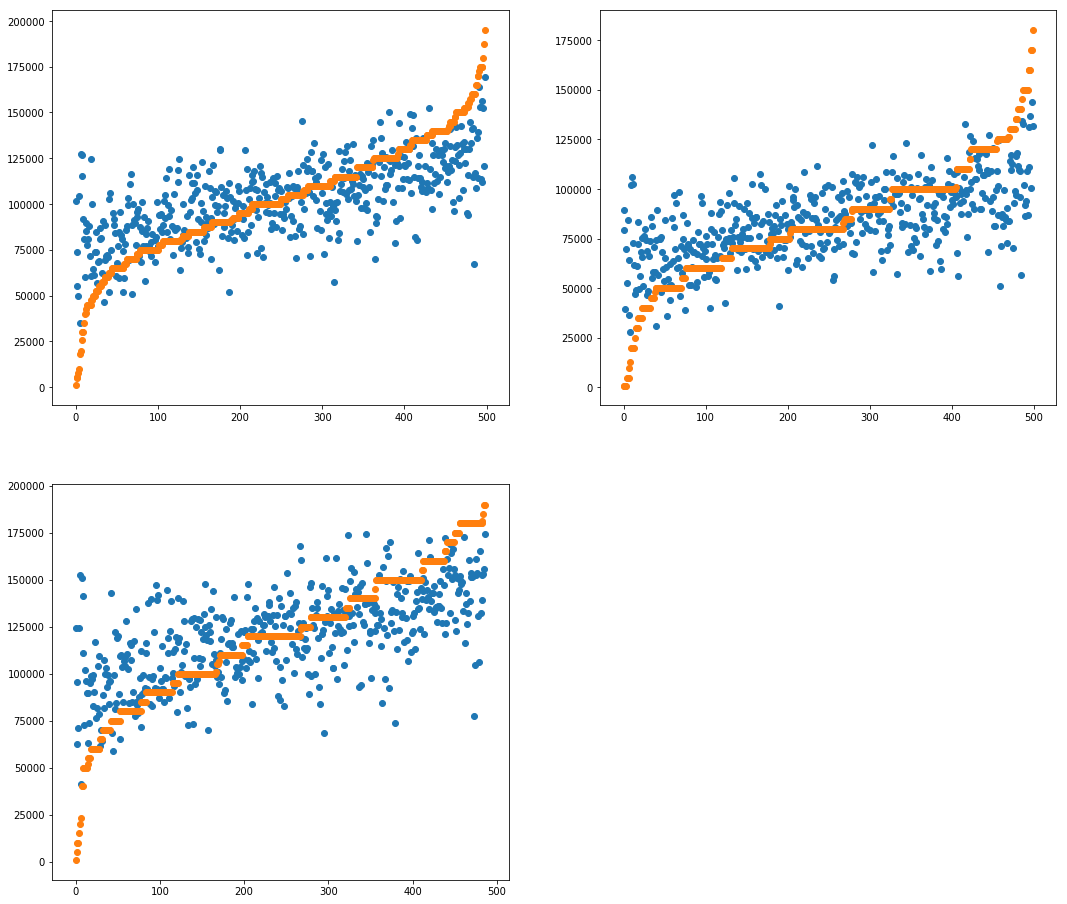

In [3]:
import matplotlib.pyplot as plt


i=1
fig=plt.figure(figsize=(18, 16))

for el in salary_options:
    y_test_predictions = salary_model_data[el]["y_pred"]
    y_train_predictions = salary_model_data[el]["y_pred_train"]
    
    y_test_true= salary_model_data[el]["y_test"]
    y_train_true = salary_model_data[el]["y_train"]
    
    #true_v_pred = list(zip(y_test_true, y_test_predictions))
    #true_v_pred.sort()
        
    #true_sorted = [x[0] for x in true_v_pred]
    #pred_sorted = [x[1] for x in true_v_pred]
    
    true_sorted_indices = np.argsort(y_test_true)
    true_sorted = [y_test_true[true_sorted_indices[i]] for i in range(len(true_sorted_indices))]
    pred_sorted = [y_test_predictions[true_sorted_indices[i]] for i in range(len(true_sorted_indices))]
    
    true_sorted = [x for x in true_sorted if x < 200000]
    pred_sorted = pred_sorted[0:len(true_sorted)]
    
    xvals = range(len(true_sorted))
    plt.subplot(2,2,i)
    
    plt.scatter(x=xvals, y=pred_sorted)
    plt.scatter(x=xvals, y=true_sorted)
    i+=1

plt.show()
    

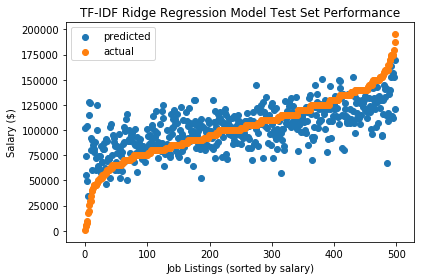

In [4]:
y_test_predictions = salary_model_data["avg_salary"]["y_pred"]
y_train_predictions = salary_model_data["avg_salary"]["y_pred_train"]
    
y_test_true= salary_model_data["avg_salary"]["y_test"]
y_train_true = salary_model_data["avg_salary"]["y_train"]

true_sorted_indices = np.argsort(y_test_true)
true_sorted = [y_test_true[true_sorted_indices[i]] for i in range(len(true_sorted_indices))]
pred_sorted = [y_test_predictions[true_sorted_indices[i]] for i in range(len(true_sorted_indices))]

true_sorted = [x for x in true_sorted if x < 200000]
pred_sorted = pred_sorted[0:len(true_sorted)]

xvals = range(len(true_sorted))

plt.scatter(x=xvals, y=pred_sorted)
plt.scatter(x=xvals, y=true_sorted)
plt.xlabel("Job Listings (sorted by salary)")
plt.ylabel("Salary ($)")
plt.legend(["predicted", "actual"])
plt.title("TF-IDF Ridge Regression Model Test Set Performance")

plt.tight_layout()
plt.savefig("tfidf_n.png", dpi=1000)

Now to try the SVM

In [5]:
min_sal_buckets = range(50000,210000,10000)
num_buckets = len(min_sal_buckets)+1

print(num_buckets)

def min_class_bucket(salary):
    proper_bucket = -1

    if salary < min_sal_buckets[0]:
        return 0

    elif salary >= min_sal_buckets[-1]:
        return len(min_sal_buckets)

    for i in range(1,len(min_sal_buckets)):

        if salary >= min_sal_buckets[i-1] and salary < min_sal_buckets[i]:
            return i

17


In [6]:
for el in salary_options:
    y_test_true= salary_model_data[el]["y_test"]
    y_train_true = salary_model_data[el]["y_train"]
    
    y_test_bucket_true = []
    y_train_bucket_true = []
    
    for t in y_test_true:
        y_test_bucket_true.append(min_class_bucket(t))
    
    for t in y_train_true:
        y_train_bucket_true.append(min_class_bucket(t))

    salary_model_data[el]["y_test_bucket"] = y_test_bucket_true
    salary_model_data[el]["y_train_bucket"] = y_train_bucket_true
        

In [7]:
from sklearn.svm import LinearSVC, SVC

for el in salary_options:
    salary_model_data[el]["svm_model"] = SVC(gamma = 'scale')
    
    X_t = salary_model_data[el]["X_train"]
    y_t = salary_model_data[el]["y_train_bucket"]
    salary_model_data[el]["svm_model"].fit(X_t, y_t)
    
    
    

In [8]:
from sklearn.metrics import accuracy_score

for el in salary_options:
    X_train = salary_model_data[el]["X_train"]
    X_test = salary_model_data[el]["X_test"]
    y_train_pred = salary_model_data[el]["svm_model"].predict(X_train)
    y_test_pred = salary_model_data[el]["svm_model"].predict(X_test)
    
    salary_model_data[el]["svm_train_pred"] = y_train_pred
    salary_model_data[el]["svm_test_pred"] = y_test_pred
    
    y_train_true = salary_model_data[el]["y_train_bucket"]
    y_test_true = salary_model_data[el]["y_test_bucket"]
    
    
    
    print(el + " train accuracy: " + str(accuracy_score(y_train_pred, y_train_true)) )
    print(el + " test accuracy: " + str(accuracy_score(y_test_pred, y_test_true)) )

avg_salary train accuracy: 0.14373381915811678
avg_salary test accuracy: 0.136
min_salary train accuracy: 0.17834883497938442
min_salary test accuracy: 0.156
max_salary train accuracy: 0.16329465912359767
max_salary test accuracy: 0.15


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 16]
[ 842  814 1087 1424 1795 1077 1664  426  744  210  127  133   41   22
   12   11]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
[842, 814, 1087, 1424, 1795, 1077, 1664, 426, 744, 210, 127, 133, 41, 22, 12, 0, 11]
17


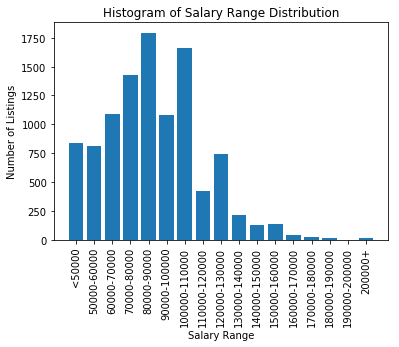

In [9]:
import matplotlib.pyplot as plt

buckets_train =  salary_model_data["min_salary"]["y_train_bucket"] 
unique, counts = np.unique(buckets_train, return_counts=True)

print((unique))
print((counts))

unique = unique.tolist()
counts = counts.tolist()

unique.insert(15,15)
counts.insert(15,0)

print((unique))
print((counts))

label_bars = ["<50000", "50000-60000","60000-70000", "70000-80000", "80000-90000", "90000-100000", "100000-110000", "110000-120000", "120000-130000", "130000-140000", "140000-150000", "150000-160000", "160000-170000", "170000-180000" , "180000-190000" , "190000-200000" , "200000+" ]
print(len(label_bars))
plt.bar(x=unique, height=counts)
plt.xticks(unique, label_bars)
plt.xticks(rotation=90)
plt.xlabel("Salary Range")
plt.ylabel("Number of Listings")
plt.title("Histogram of Salary Range Distribution")
plt.show()

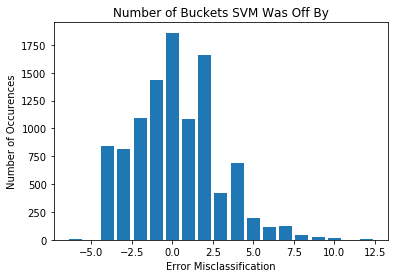

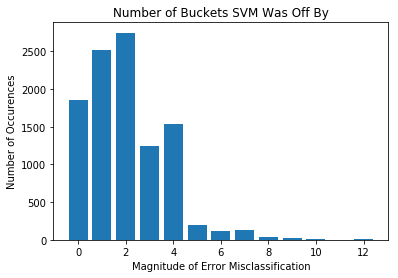

In [10]:
import numpy as np
import matplotlib.pyplot as plt
#Lets look at how far we are off
Y_train =  salary_model_data["min_salary"]["y_train_bucket"] 
Y_train_pred =  salary_model_data["min_salary"]["svm_train_pred"] 

dif_matrix = Y_train - Y_train_pred
unique, counts = np.unique(dif_matrix, return_counts=True)
my_class_counts = dict(zip(unique, counts))

dif_matrix_abs = np.abs(dif_matrix)
unique, counts = np.unique(dif_matrix_abs, return_counts=True)
my_class_counts_abs = dict(zip(unique, counts))

x_count = [int(v) for v in my_class_counts.keys()]
y_count = [my_class_counts[v] for v in my_class_counts.keys()]

x_count_abs = [int(v) for v in my_class_counts_abs.keys()]
y_count_abs = [my_class_counts_abs[v] for v in my_class_counts_abs.keys()]

plt.clf()
plt.bar(x_count,y_count)
plt.xlabel('Error Misclassification')
plt.ylabel('Number of Occurences')
plt.title('Number of Buckets SVM Was Off By')
plt.show()

plt.clf()
plt.bar(x_count_abs,y_count_abs)
plt.xlabel('Magnitude of Error Misclassification')
plt.ylabel('Number of Occurences')
plt.title('Number of Buckets SVM Was Off By')
plt.show()


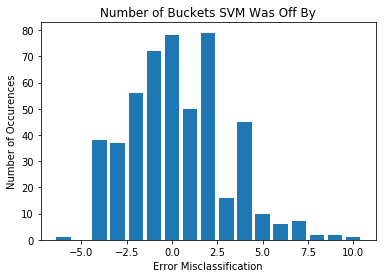

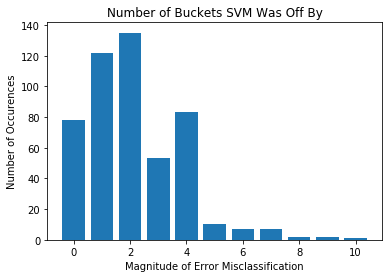

In [11]:
import numpy as np
#Lets look at how far we are off
Y_train =  salary_model_data["min_salary"]["y_test_bucket"] 
Y_train_pred =  salary_model_data["min_salary"]["svm_test_pred"] 

dif_matrix = Y_train - Y_train_pred
unique, counts = np.unique(dif_matrix, return_counts=True)
my_class_counts = dict(zip(unique, counts))

dif_matrix_abs = np.abs(dif_matrix)
unique, counts = np.unique(dif_matrix_abs, return_counts=True)
my_class_counts_abs = dict(zip(unique, counts))

x_count = [int(v) for v in my_class_counts.keys()]
y_count = [my_class_counts[v] for v in my_class_counts.keys()]

x_count_abs = [int(v) for v in my_class_counts_abs.keys()]
y_count_abs = [my_class_counts_abs[v] for v in my_class_counts_abs.keys()]

plt.clf()
plt.bar(x_count,y_count)
plt.xlabel('Error Misclassification')
plt.ylabel('Number of Occurences')
plt.title('Number of Buckets SVM Was Off By')
plt.show()

plt.clf()
plt.bar(x_count_abs,y_count_abs)
plt.xlabel('Magnitude of Error Misclassification')
plt.ylabel('Number of Occurences')
plt.title('Number of Buckets SVM Was Off By')
plt.show()


In [12]:

total_rec = sum(counts)
zero_to_one_bucket = sum(counts[0:2])
print("Percentage off by 1 bucket or less on test set: " + str( zero_to_one_bucket / total_rec) )


Percentage off by 1 bucket or less on test set: 0.4
